# TUTORIAL DEEP LEARNING: Convolutional Neural Network For Medicinal Plant Recognition.

At the first step we will import all the librairies that we need for our work.

In [1]:
import os, cv2
import random
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
import keras.backend as K
from keras.models import Model, Sequential, load_model
from keras import Input
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, BatchNormalization, Dropout, InputLayer
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from keras.applications import VGG19, VGG16
from keras.preprocessing.image import ImageDataGenerator
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
K.clear_session()

Using TensorFlow backend.


Then we set the path to the "medicinales" plants images for training and testing our model. 

In [2]:
train_dir = 'C:\\Users\\Beranger\\Desktop\\Datasets\\Images\\images_atut\\training\\'
test_dir = 'C:\\Users\\Beranger\\Desktop\\Datasets\\Images\\images_atut\\test\\'
list_repo = os.listdir(train_dir)


We will ensure that all the categories of plants are well-balanced. Unless our model will learn the more predomintant class and won't learn the fewer class of plants.

In [3]:
print('The number of plants per class is: ')
print('===================================')
for rep in list_repo:

    images = os.listdir(train_dir+rep+'\\')
    length = len(images)
    print(rep, '---->',length)
print('===================================')

The number of plants per class is: 
BAMBUSA_SPINOSA ----> 1110
BUCHHOLZIA_MACROPHYLLA ----> 1110
CHRYSOPHYLUM_CAINITO ----> 1110
MELIA_AZEDARACH ----> 1110
RAUWOLFIA_VOMITORIA ----> 1110


Now let's see several samples of our plants in order to know what they look like.

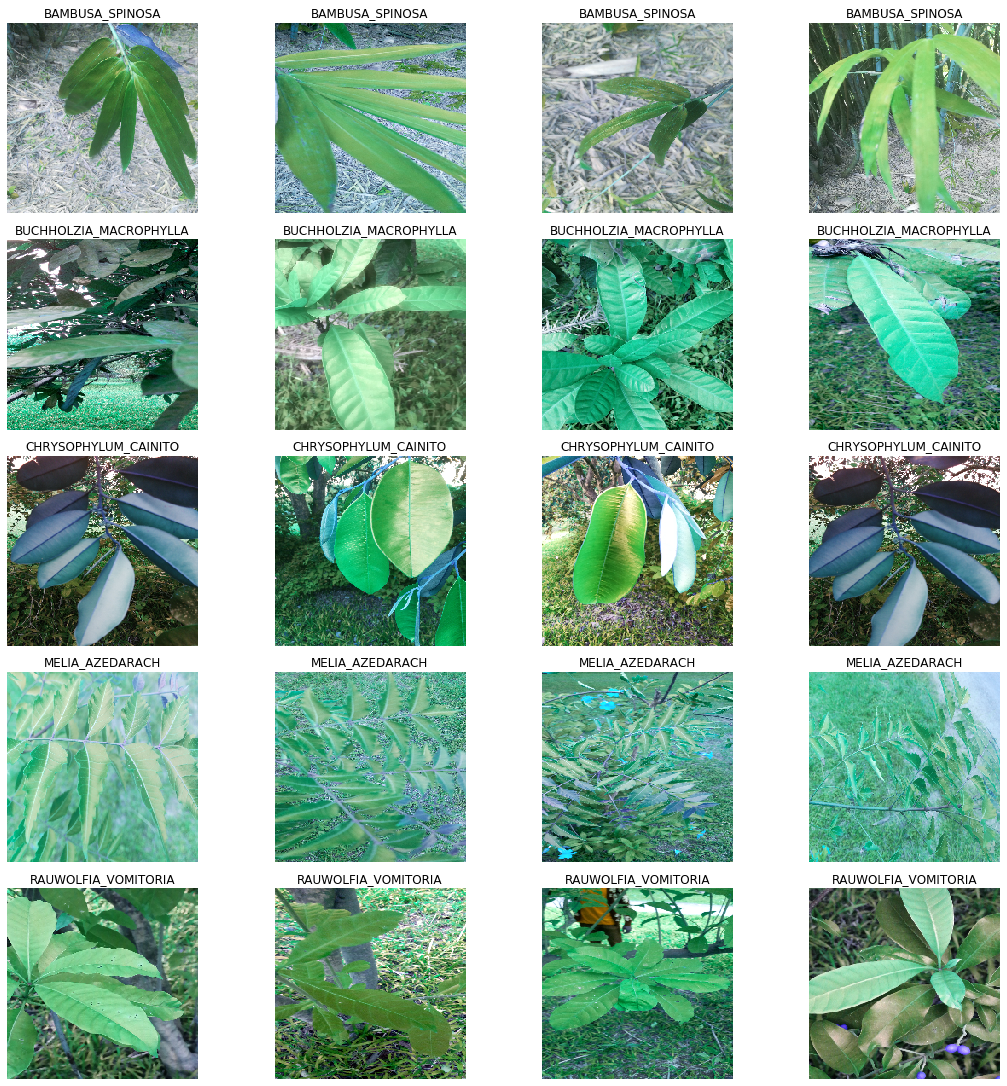

In [4]:

fig, axs = plt.subplots(5, 4, figsize=(15, 15))

for i in range(5):
    for j in range(4):
        choice = random.choice(os.listdir(train_dir+list_repo[i]+'\\')) 
        img = cv2.imread(train_dir+list_repo[i]+'\\'+choice)
        img = cv2.resize(img, (224, 224))
        axs[i, j].set_title(list_repo[i])
        axs[i, j].imshow(img)
        #axs[i, j].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY), cmap="gray")
        axs[i, j].axis('off')

    
    
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)


In [5]:
def custom_printer(message):
    """This function is just a wrapper for our print function.
    """
    print("===="*16)
    print(" ------ "+ message + " ------")
    print("===="*16)
    

def all_generator(BATCH_SIZE=32, TARGET_SIZE=(224, 224)):
    """This function build all the generators and return them in a dictionnary.
    """

    train_datagen = ImageDataGenerator(rotation_range=40,
                                       rescale = 1/255, 
                                       width_shift_range=0.2,
                                       height_shift_range=0.2,
                                       shear_range=0.2,
                                       zoom_range=0.4,
                                       brightness_range=[0.0, 0.4],
                                       horizontal_flip=True,
                                       vertical_flip=True,
                                       validation_split=0.2,
                                       fill_mode='nearest')

    test_datagen = ImageDataGenerator(rescale = 1/255)

    train_generator = train_datagen.flow_from_directory(train_dir, 
                                                        target_size=TARGET_SIZE,
                                                        batch_size=BATCH_SIZE,
                                                        class_mode='categorical')

    valid_generator = train_datagen.flow_from_directory(train_dir, 
                                                        target_size=TARGET_SIZE,
                                                        batch_size=BATCH_SIZE,
                                                        class_mode='categorical',
                                                        subset='validation')


    test_generator = test_datagen.flow_from_directory(test_dir, 
                                                       target_size=TARGET_SIZE,
                                                       batch_size=BATCH_SIZE,
                                                       class_mode='categorical')
    
    output = (train_generator, valid_generator, test_generator)
    
    
    return output


In [6]:
def build_tl_model():
    """
    This function takes all the layers of VGG16 to the 4th last ones.
    Add them to a personalized model and freezes them before adding our stacck of dense layers.
    What is a bit special here is that we add some batchnormalization between
    the layers to speed the training and have better result.

    """
    # We create an empty model
    model = Sequential()
    # We add the convolutionnal base from VGG16 spacing by batchnormalization
    # each 03 layers
    for (i, lay) in enumerate(VGG16().layers[:-4]):
        lay.trainable = False
        model.add(lay) 
        if i % 3 == 0 and i != 0:
            model.add(BatchNormalization())
        if i % 5 == 0 and i != 0:
            model.add(Dropout(0.2))  

    # Then we add our stack of dense layers
    model.add(Flatten())
    model.add(Dropout(0.2))
    model.add(Dense(32, activation="relu"))
    model.add(Dense(5, activation="softmax"))
    
    # We can now compile our model
    model.compile(loss="categorical_crossentropy",
                  optimizer="rmsprop",
                  metrics=['accuracy'])

    
    print(model.summary())
    
    return model
    

In [7]:
def model_trainer(train_generator, valid_generator, test_generator,
                  EPOCHS=1, PATIENCE=1, TRAIN_STEPS_EPOCH=220, 
                  VAL_STEPS_EPOCH=50):
    """
    This function perfoms a transfert learning with a convultionnal base of VGG16 frozen.
    And ends by fine tuning the model.
    
    """
    
    # Here we will define the callbacks that we will use during the model training.

    callbacks_freez = [ModelCheckpoint("checkpoint_freez.h5",
                                    monitor='val_loss',
                                    save_best_only=True), 
                     EarlyStopping(monitor='val_loss',
                                   patience=PATIENCE)]
  
    # Then we build the model
    model_atut = build_tl_model() 
    # We effectively train it 
    history_freez = model_atut.fit_generator(train_generator,
                             steps_per_epoch=TRAIN_STEPS_EPOCH,
                             epochs=EPOCHS,
                             callbacks=callbacks_freez,
                             validation_data=valid_generator,
                             validation_steps=VAL_STEPS_EPOCH,
                             verbose=1)
    
    custom_printer("THE FINE TUNING IS STARTING.")
    
    callbacks_ft = [ModelCheckpoint("checkpoint_ft.h5",
                                    monitor='val_loss',
                                    save_best_only=True), 
                     EarlyStopping(monitor='val_loss',
                                   patience=PATIENCE)]
    # We start by setting to trainable all the parameters of our model.  
    
    model_atut.trainable = False
    model_ft = Sequential()
    model_ft.add(InputLayer(input_shape=(224, 224, 3)))
    
    for lay in model_atut.layers[:-11]:
        print("Before ", lay.name, lay.trainable)
        lay.trainable = False
        model_ft.add(lay)
        print("After ", lay.name, lay.trainable)
        print("\n")
        
    for lay in model_atut.layers[-11:]:
        print("Before ", lay.name, lay.trainable)
        lay.trainable = True
        model_ft.add(lay)
        print("After ", lay.name, lay.trainable)
        print("\n")
    
    model_ft.compile(loss="categorical_crossentropy",
                  optimizer="rmsprop",
                  metrics=['accuracy'])
    
    print(model_ft.summary())
            
    history_ft = model_ft.fit_generator(train_generator,
                             steps_per_epoch=TRAIN_STEPS_EPOCH,
                             epochs=EPOCHS,
                             callbacks=callbacks_ft,
                             validation_data=valid_generator,
                             validation_steps=VAL_STEPS_EPOCH,
                             verbose=1)  
    
    # Evaluate on test set 
    perf = model_ft.evaluate_generator(test_generator,
                                steps=len(test_generator),
                                verbose=1)
    
    custom_printer(str(perf))

    # Save the model 
    model_ft.save("my_final_model.h5")
    custom_printer(" WELL DONE YOUR FINAL MODEL IS READY.")
    
    return model_ft , history_ft, history_freez



In [8]:
%%time
model_ft , history_ft, history_freez = model_trainer(*all_generator(), EPOCHS=200, PATIENCE=10)

Found 5547 images belonging to 5 classes.
Found 1107 images belonging to 5 classes.
Found 997 images belonging to 5 classes.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 112, 112, 64)      256       
_________________________________________________________________
block2_conv1 (Conv2D)       

Epoch 21/200
220/220 [==============================] - 601s 3s/step - loss: 0.2118 - acc: 0.9276 - val_loss: 0.3463 - val_acc: 0.8914
Epoch 22/200
220/220 [==============================] - 601s 3s/step - loss: 0.2062 - acc: 0.9287 - val_loss: 0.4228 - val_acc: 0.8853
Epoch 23/200
220/220 [==============================] - 604s 3s/step - loss: 0.2124 - acc: 0.9277 - val_loss: 0.2686 - val_acc: 0.9067
Epoch 24/200
220/220 [==============================] - 603s 3s/step - loss: 0.2077 - acc: 0.9283 - val_loss: 0.2467 - val_acc: 0.9212
Epoch 25/200
220/220 [==============================] - 606s 3s/step - loss: 0.2043 - acc: 0.9286 - val_loss: 0.2467 - val_acc: 0.9049
Epoch 26/200
220/220 [==============================] - 601s 3s/step - loss: 0.1911 - acc: 0.9369 - val_loss: 0.2238 - val_acc: 0.9314
Epoch 27/200
220/220 [==============================] - 602s 3s/step - loss: 0.1879 - acc: 0.9331 - val_loss: 0.2953 - val_acc: 0.9036
Epoch 28/200
220/220 [==============================] -

220/220 [==============================] - 599s 3s/step - loss: 0.2976 - acc: 0.8998 - val_loss: 0.3286 - val_acc: 0.8677
Epoch 6/200
220/220 [==============================] - 592s 3s/step - loss: 0.3004 - acc: 0.9024 - val_loss: 0.5851 - val_acc: 0.8545
Epoch 7/200
220/220 [==============================] - 591s 3s/step - loss: 0.2664 - acc: 0.9172 - val_loss: 1.6232 - val_acc: 0.7076
Epoch 8/200
220/220 [==============================] - 597s 3s/step - loss: 0.2409 - acc: 0.9223 - val_loss: 0.2875 - val_acc: 0.8960
Epoch 9/200
220/220 [==============================] - 594s 3s/step - loss: 0.2400 - acc: 0.9245 - val_loss: 0.1707 - val_acc: 0.9422
Epoch 10/200
220/220 [==============================] - 594s 3s/step - loss: 0.2207 - acc: 0.9309 - val_loss: 0.6497 - val_acc: 0.8519
Epoch 11/200
220/220 [==============================] - 596s 3s/step - loss: 0.2208 - acc: 0.9327 - val_loss: 0.5308 - val_acc: 0.8621
Epoch 12/200
220/220 [==============================] - 595s 3s/step - l

# END